In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.utils import Bunch

%matplotlib inline


In [2]:
import cv2

def load_image_files(images_dir_path, dimension=(224, 224)):
    sift = cv2.SIFT_create()
    
    images_dir = Path(images_dir_path)
    directories = [directory for directory in images_dir.iterdir()]
    classes = [class_directory.name.lower() for class_directory in directories]

    data = []

    for class_index, directory in enumerate(directories):
        class_images_cnt = 0
        for file in directory.iterdir():
            class_images_cnt += 1

        for i, file in enumerate(directory.iterdir()):
            image = cv2.imread(file.as_posix(), cv2.IMREAD_COLOR)
            image = cv2.resize(image, dimension)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            keypoints, descriptors = sift.detectAndCompute(image_gray, None)

            bunch = Bunch(
                image=image,
                image_resized=image,
                image_gray=image_gray,
                sift_keypoints=keypoints,
                sift_descriptors=descriptors,
                class_index=class_index,
                class_name=classes[class_index],
            )

            data.append(bunch)

    return data

In [3]:
dataset = load_image_files("groceries", dimension=(224, 224))
img_shape = (224, 224, 3)
num_classes = 25

# train_dataset, test_dataset = load_image_files("cifar-10", dimension=(64, 64))
# img_shape = (64, 64, 3)
# num_classes = 10

print(len(dataset))

4947


In [4]:
import random
%matplotlib inline

sample_image_index = random.randint(0, len(dataset))

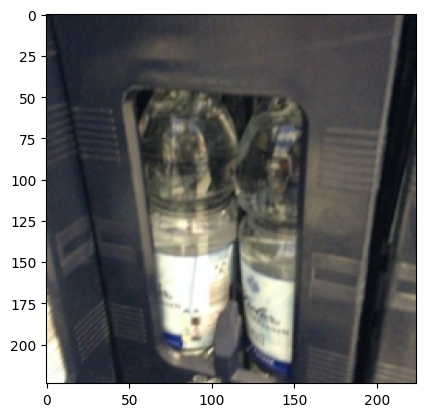

In [5]:

plt.imshow(dataset[sample_image_index].image)
plt.show()

In [6]:
x_descriptors = [bunch.sift_descriptors for bunch in dataset]
x_keypoints = [bunch.sift_keypoints for bunch in dataset]
y = [bunch.class_index for bunch in dataset]

In [7]:

def filter_descriptors(x_descriptors, x_keypoints, y_labels, min_scale=1):
    x_res = []
    y_res = []

    for des, kp, label in zip(x_descriptors, x_keypoints, y_labels):
        keypoints_filtered = [kp for kp, _ in zip(kp, des) if kp.size >= min_scale]
        des_filtered = np.array([des for kp, des in zip(kp, des) if kp.size >= min_scale])

        if len(keypoints_filtered) > 0:
            x_res.append(des_filtered)
            y_res.append(label)
    
    return x_res, y_res

def pad_descriptors(x_descriptors):
    x_res = []
    max_length = max(len(des) for des in x_descriptors)

    for des in x_descriptors:
        if des is not None:
            x_res.append(np.pad(des, ((0, max_length - len(des)), (0, 0)), mode='constant'))

    return x_res


In [8]:
x_flattened_padded_descriptors = np.array([des.flatten() for des in pad_descriptors(x_descriptors)])

In [9]:
x_mean, x_eigenvectors = cv2.PCACompute(x_flattened_padded_descriptors, mean=None, retainedVariance=0.95)

In [10]:
x_reduced_descriptors = cv2.PCAProject(x_flattened_padded_descriptors, x_mean, x_eigenvectors)

In [11]:
print(np.array(x_reduced_descriptors).shape)
print(np.array(y).shape)

(4947, 3872)
(4947,)


In [50]:
x_train_reduced_descriptors = []
y_train = []

x_test_reduced_descriptors = []
y_test = []

import random
zipped = list(zip(x_reduced_descriptors, y))
random.shuffle(zipped)

for i in range(len(zipped)):
    if i / len(zipped) > 0.2:
        x_train_reduced_descriptors.append(zipped[i][0].flatten())
        y_train.append(zipped[i][1])
        continue

    x_test_reduced_descriptors.append(zipped[i][0].flatten())
    y_test.append(zipped[i][1])

In [51]:
x_train = np.asarray(x_train_reduced_descriptors)
x_test = np.asarray(x_train_reduced_descriptors)

In [52]:
import cv2

svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER, 500, 1e-6))
svm.train(x_train.astype(np.float32), cv2.ml.ROW_SAMPLE, np.asarray(y_train))

True

In [53]:
y_pred = svm.predict(np.asarray(x_test_reduced_descriptors).astype(np.float32))[1]
y_pred = np.asarray([x[0] for x in y_pred]).astype(np.int32)

In [54]:
np.asarray(y_test)

array([15,  8,  0,  6,  8, 18,  6,  7, 18, 19, 13, 14,  3, 14, 19,  8, 24,
       13, 20, 23, 19, 15,  6, 15, 14, 12,  6, 21, 11,  0,  9,  0,  7, 14,
       24,  1,  5, 11, 14, 16, 12, 10, 16, 19, 14, 18, 17, 20, 14, 11, 15,
       23,  0, 18, 11,  7, 15, 11, 15,  9, 15, 19,  7, 15, 12, 12, 22,  3,
        9, 23, 23, 18, 21, 18, 22, 12, 10, 21, 16,  9,  9, 12, 21, 15, 21,
       16, 14, 22,  5,  5,  6, 18,  9, 23,  3, 18,  1, 21, 15,  6,  3,  8,
       18,  8,  4, 19, 23,  3, 23, 20,  3, 19, 18, 24,  6, 21, 14,  8, 18,
       16, 15, 18, 15, 15, 13, 10, 14, 11,  6, 18, 14,  8, 14, 15, 17, 11,
       19, 18,  3,  5,  4,  7, 24,  2, 11,  2, 23,  3, 21, 20, 10, 18, 18,
       12, 21, 15, 15, 11, 18, 12, 10,  5,  8,  5, 21, 14, 20, 20, 24,  7,
        7,  3,  0,  9, 12, 23,  9, 21, 12,  5, 21,  2,  5,  9,  8, 10, 23,
        5, 21, 21,  7,  4, 11,  7, 14, 21, 24, 12,  3, 14, 23,  8, 16, 15,
       13, 15, 10, 15, 19, 22,  0, 23,  1,  7, 10, 11,  8, 12, 24, 13,  2,
       11, 14,  4, 23, 12

In [55]:
np.asarray(y_pred)

array([15, 21, 21, 15,  3, 18,  6, 16,  0, 15, 15,  9, 10, 14, 14,  7,  9,
        9, 12, 23, 14,  3, 21, 15, 21,  9, 12, 21,  5,  7,  9, 18, 21, 21,
       13, 18, 21,  8,  9, 14,  0, 10,  7, 15,  5, 21,  9, 14,  3, 15, 15,
        8, 14, 21, 15, 12, 13,  9,  9, 15,  3, 15, 15, 22, 14, 19, 12,  8,
        5, 22, 21, 18, 18, 21, 22, 13, 19, 21, 14, 22,  9,  9, 21, 13, 21,
       21, 12,  6,  5, 12, 11, 12, 22, 10, 15, 18, 18, 11,  3, 13, 15, 15,
       12, 15, 21, 19, 23, 14, 23, 14, 10, 10, 22,  8, 10, 21, 14,  3, 15,
        5, 21,  5, 13, 21, 13,  8, 21,  9, 18,  3, 19, 13, 21, 21,  6, 21,
       14, 18, 21,  3, 13, 18,  9,  5, 12, 13, 22, 21,  9,  5, 13, 18, 10,
        9, 21,  5, 18, 18,  9, 12, 10,  3, 15, 21, 18, 13, 12,  7, 24, 18,
       21,  3, 21, 21, 15, 12, 12, 21, 18, 17, 21,  7,  5, 18,  8,  3, 19,
       21, 21,  4, 14,  0, 12, 12,  9, 21, 21, 14,  3, 14, 12, 24, 22, 22,
       21,  3, 19, 19, 19,  9, 22, 23, 13, 14,  3, 22,  9, 12,  3, 12, 18,
       21,  3, 18,  9,  9

In [56]:
print(metrics.classification_report(np.asarray(y_test), y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.14      0.04      0.07        23
           2       0.00      0.00      0.00        29
           3       0.21      0.35      0.26        49
           4       0.11      0.03      0.05        29
           5       0.19      0.11      0.14        35
           6       0.20      0.10      0.13        42
           7       0.06      0.03      0.04        34
           8       0.11      0.06      0.08        33
           9       0.17      0.27      0.21        63
          10       0.08      0.07      0.07        29
          11       0.00      0.00      0.00        38
          12       0.16      0.20      0.18        59
          13       0.14      0.22      0.17        36
          14       0.16      0.20      0.18        60
          15       0.09      0.11      0.10        70
          16       0.00      0.00      0.00        21
          17       0.00    

In [ ]:
svm.save("sift_svm_cifar10_f32.dat")
# svm.save("sift_svm_groceries_f32.dat")

In [ ]:
svm = cv2.ml.SVM_load("sift_svm_cifar10_f32.dat")
# svm = cv2.ml.SVM_load("sift_svm_groceries_f32.dat")
svm.predict(x_test.astype(np.float32))

(0.0,
 array([[3.],
        [0.],
        [0.],
        ...,
        [9.],
        [2.],
        [4.]], dtype=float32))